## 3.2 Comparação com baselines ingênuos

Objetivo: Comparar resultados e métricas obtidas com modelos ingênuos a fim de entender quão bom é nosso modelo

### Importação das bibliotecas

In [45]:
import pandas as pd
import joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

### Carregando os dados

In [46]:
# Carregando os dados já divididos e processados
X_train = pd.read_csv('../data/processed/X_train.csv', sep=';')
X_test = pd.read_csv('../data/processed/X_test.csv', sep=';')
y_train = pd.read_csv('../data/processed/y_train.csv', sep=';').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv', sep=';').squeeze()

print(f"Treino: {X_train.shape[0]} amostras × {X_train.shape[1]} features")
print(f"Teste: {X_test.shape[0]} amostras × {X_test.shape[1]} features")

Treino: 662 amostras × 13 features
Teste: 285 amostras × 13 features


### Carregando o melhor modelo

In [47]:
model_path = Path('../models/best_model.pkl')
best_model = joblib.load(model_path)

### Definindo baselines e os treinando

Para os baselines escolhemos três modelos ingênuos:

- **Aleatório**: realiza previsões escolhendo aleatoriamente entre as duas classes, com probabilidades iguais.
- **Classe mais frequente**: sempre prevê a classe com maior predominância no conjunto de dados.
- **Estratificado**: realiza previsões aleatórias, mas respeitando a distribuição das classes observada no conjunto de treinamento.

In [48]:
baselines = {
    'Aleatório': DummyClassifier(strategy='uniform'),
    'Classe mais Frequente': DummyClassifier(strategy='most_frequent'),
    'Estratificado': DummyClassifier(strategy='stratified')
}

for name, model in baselines.items():
    model.fit(X_train, y_train)

print("Baselines criados e treinados.")

Baselines criados e treinados.


### Avaliando e fazendo comparativo

In [49]:
results_comparison = {}

y_pred_best = best_model.predict(X_test)
results_comparison['Melhor Modelo'] = {
    'Acurácia': accuracy_score(y_test, y_pred_best),
    'F1-Score': f1_score(y_test, y_pred_best, average='weighted'),
    'Precisão': precision_score(y_test, y_pred_best, average='weighted'),
    'Recall': recall_score(y_test, y_pred_best, average='weighted')
}

for name, model in baselines.items():
    y_pred = model.predict(X_test)
    results_comparison[name] = {
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'Precisão': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted')
    }

df_results = pd.DataFrame(results_comparison).T
print("\n" + "="*70)
print("COMPARAÇÃO: MELHOR MODELO vs BASELINES")
print("="*70)
print(df_results.round(4))


COMPARAÇÃO: MELHOR MODELO vs BASELINES
                       Acurácia  F1-Score  Precisão  Recall
Melhor Modelo            0.9544    0.9544    0.9547  0.9544
Aleatório                0.5263    0.5265    0.5267  0.5263
Classe mais Frequente    0.5579    0.3996    0.3112  0.5579
Estratificado            0.5123    0.5136    0.5159  0.5123


C:\Users\Guilherme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


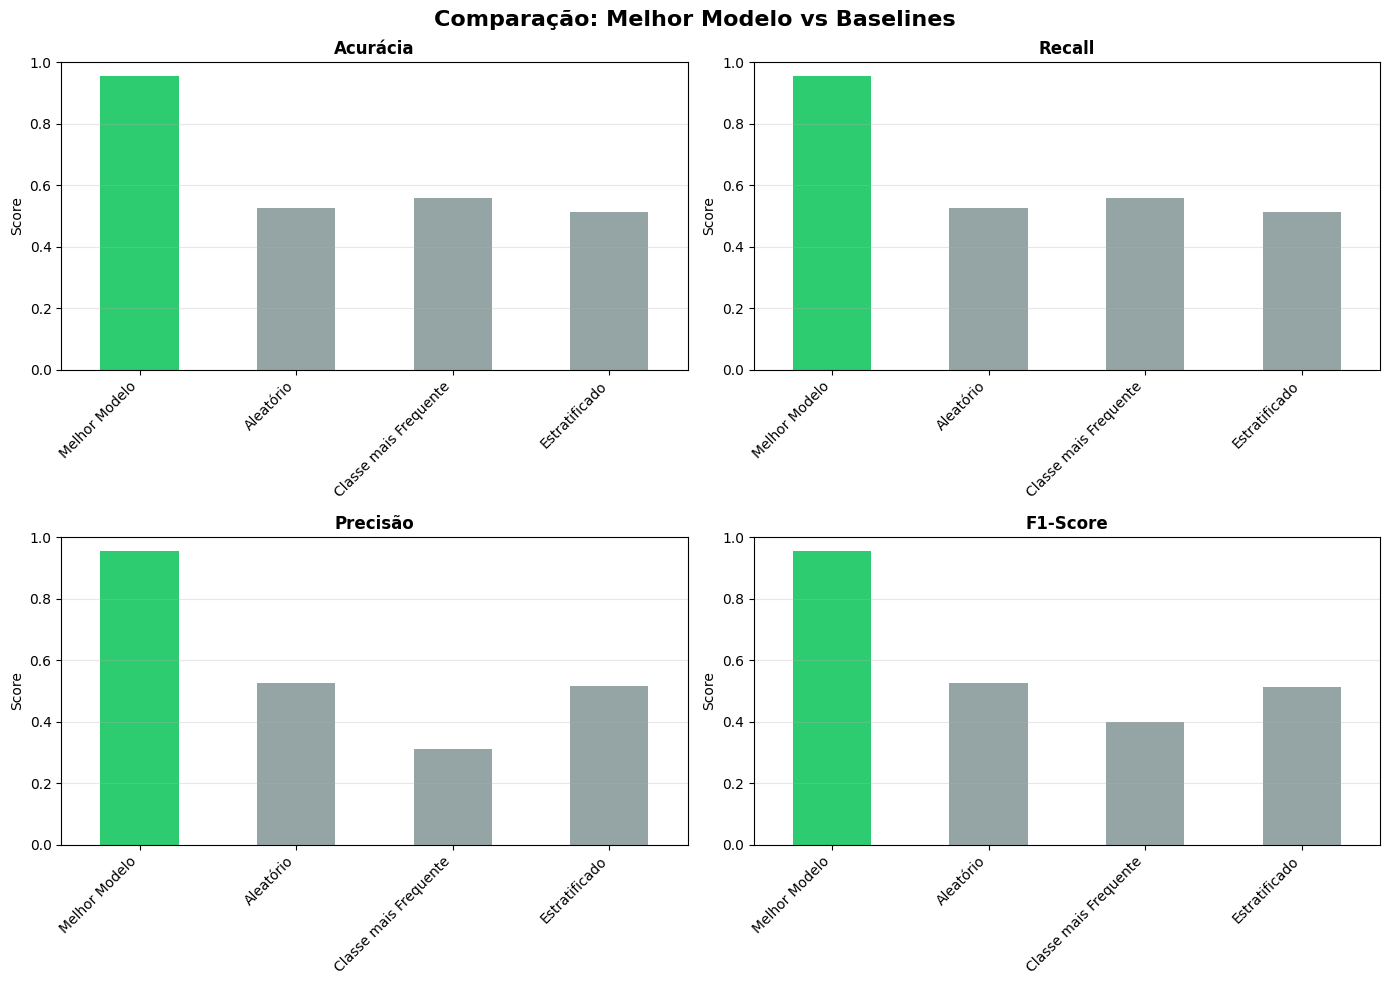

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparação: Melhor Modelo vs Baselines', fontsize=16, fontweight='bold')

metrics = ['Acurácia', 'Recall', 'Precisão', 'F1-Score']
colors = ['#2ecc71' if i == 0 else '#95a5a6' for i in range(len(df_results))]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    df_results[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(metric, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

O gráfico evidencia que o melhor modelo supera de forma consistente todas as baselines ingênuas em todas as métricas avaliadas. Esse ganho é particularmente relevante na métrica de recall, definida como a mais importante para o problema em questão, indicando que o modelo proposto é significativamente mais eficaz em identificar corretamente os exemplos da classe positiva.

Esse resultado sugere que o modelo aprende padrões relevantes dos dados, indo além de estratégias triviais como previsões aleatórias ou baseadas apenas na distribuição das classes.

### Resumo e conclusões

In [51]:
# Resumo e conclusões
print("\n" + "="*70)
print("ANÁLISE DE MELHORIA")
print("="*70)

best_row = df_results.loc['Melhor Modelo']
worst_baseline = df_results.loc[df_results.index != 'Melhor Modelo'].max()

for metric in metrics:
    improvement = (best_row[metric] - worst_baseline[metric]) / worst_baseline[metric] * 100
    print(f"{metric:12}: {improvement:+.2f}% de melhoria vs melhor baseline")


ANÁLISE DE MELHORIA
Acurácia    : +71.07% de melhoria vs melhor baseline
Recall      : +71.07% de melhoria vs melhor baseline
Precisão    : +81.26% de melhoria vs melhor baseline
F1-Score    : +81.28% de melhoria vs melhor baseline


Os resultados mostram que o melhor modelo apresenta um desempenho substancialmente superior em relação às baselines ingênuas em todas as métricas avaliadas.

Em comparação com o melhor baseline, o modelo obteve melhorias de aproximadamente 71% em acurácia, 71% em recall, 81% em precisão e 81% em F1-score.

Esses ganhos indicam que o modelo proposto consegue explorar padrões relevantes nos dados, superando de forma consistente abordagens triviais baseadas em aleatoriedade ou na distribuição das classes.